#### This notebook does the following:
1. Clean UK Covid data and standardise the names.
2. Convert UK Covid data collected at Lower Tier Local Authority (LTLA) level to Upper Tier Local Authority (UTLA) and regional levels.
3. Calculate UTLA and regional level neighbours from LTLA level neighbours computed by Klaus.

Author: Kyuhwa Lee (kyuhwa.lee@ibm.com)


#### UK Lower Tier Local Authority to Upper Tier Local Authority mapper
https://ibm.box.com/s/rmhcdzt30hzkoya3ryk0xlyp2lmwll7v

#### UK Local Authority District to Region mapper
https://geoportal.statistics.gov.uk/datasets/local-authority-district-to-region-april-2019-lookup-in-england

Note that local authority district is slightly different from LTLA definition but it's sufficient for our Covid data.

#### 1. Exhaustive list of areas at the regional level used in UK Covid data
South West, South East, London, East of England, West Midlands, East Midlands, Yorkshire and The Humber, North West, North East

#### 2. Exhaustive list of areas at the Upper Tier Local Authority level used in UK Covid data
York, Barnsley, Devon, Kent, Hertfordshire,
Brighton and Hove, Leicestershire, Oxfordshire, Lewisham,
Worcestershire, Ealing, Enfield, City of London,
Bradford, Nottinghamshire, Warwickshire, Camden,
Islington, Redbridge, Milton Keynes, West Sussex,
Lambeth, Derbyshire, Surrey, Southwark, Gloucestershire,
Kensington and Chelsea, Wokingham, Medway, Hampshire,
Hounslow, East Riding of Yorkshire, Nottingham, Essex,
Wigan, Leeds, Barnet, Brent, Kingston upon Thames,
Sheffield, Northamptonshire, Barking and Dagenham, Bromley,
Walsall, Merton, Wandsworth, Westminster, Birmingham,
Kingston upon Hull, City of, Wirral, Wiltshire,
Buckinghamshire, Lancashire, Bolton, Bury, Stockport,
Rotherham, Hillingdon, Newcastle upon Tyne, Liverpool,
Oldham, Torbay, Trafford, Cornwall,
Cheshire West and Chester, Staffordshire, Manchester,
Harrow, North Yorkshire, Swindon, Bracknell Forest,
Cambridgeshire, Cumbria, Bristol, City of, Lincolnshire,
Hammersmith and Fulham, Sutton, Tower Hamlets,
Southend-on-Sea, Luton, Southampton, Isle of Wight,
Wolverhampton, North Tyneside, Coventry, Waltham Forest,
Bournemouth, Christchurch and Poole, Tameside, Somerset,
Havering, Richmond upon Thames, North Lincolnshire, Derby,
Herefordshire, County of, Slough, Windsor and Maidenhead,
Darlington, Dudley, Croydon, Sunderland, Greenwich,
West Berkshire, Shropshire, Suffolk, Haringey,
South Gloucestershire, Reading, Bexley, Kirklees, Sefton,
Rochdale, Newham, County Durham, Portsmouth,
North Somerset, Warrington, Stockton-on-Tees, Doncaster,
Salford, Calderdale, Dorset, Central Bedfordshire,
Cheshire East, Thurrock, Plymouth, Blackpool,
Redcar and Cleveland, Norfolk, St. Helens, Sandwell,
Solihull, Wakefield, Bath and North East Somerset,
Leicester, East Sussex, Knowsley, Gateshead, Halton,
Stoke-on-Trent, Bedford, Northumberland,
Blackburn with Darwen, Peterborough, Middlesbrough,
Telford and Wrekin, South Tyneside, Hartlepool,
North East Lincolnshire, Rutland

In [2]:
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
try:
    import filterpy
except ImportError:
    !pip install filterpy
from filterpy.kalman import KalmanFilter, EnsembleKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise, Saver
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.rcParams.update({'figure.max_open_warning': 0})

     |████████████████████████████████| 177 kB 9.3 MB/s eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110449 sha256=2e72b658c36a7e7494250804b38963eb9e8f7a153fcef243950ace1619f2fb36
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/21/d4/10/5b385d83d179d1c83bda7424f080a92023de3b316ab2c3ae43
Successfully built filterpy


In [4]:
def name_matcher(df_ours, df_klaus, replace_pairs=None, merge_pairs=None):
    """
    Replace names and add merged areas to Klaus neighbourhood dataframe.
    Note: some values are changed in place.
    
    Input
    -----
    # modify df_ours
    replace_pairs: {area_before:area_after}
    # modify df_klaus
    merge_pairs: {merged_area:{sub_area1, sub_area2, ...}}
    """
    
    # 1. Replace names
    if replace_pairs:
        for before, after in replace_pairs.items():
            df_ours['Area name'] = df_ours['Area name'].str.replace(before, after)
    
    # 2. Merge neighbourhood area names
    if merge_pairs:
        merged = {key:[] for key in df_klaus.columns}
        for merged_area in merge_pairs:
            print('%s(merged)' % merged_area, end=': ')
            for sub_area in merge_pairs[merged_area]:
                for i, row in df_klaus[df_klaus.me_name == sub_area].iterrows():
                    if row['neighbour_name'] not in merge_pairs[merged_area]:
                        merged['me'].append('Unknown')
                        merged['neighbour'].append(row['neighbour'])
                        merged['me_name'].append(merged_area)
                        merged['neighbour_name'].append(row['neighbour_name'])
                        merged['border'].append(row['border'])
                        print(row['neighbour_name'], end=' | ')
            print()
        df_klaus = df_klaus.append(pd.DataFrame(merged)).reset_index(drop=True)
    
    return df_ours, df_klaus, merged

In [5]:
def name_matcher_uk(df_uk, df_klaus):
    '''
    replace_pairs = {
        'Hackney and City of London':'City of London',
        'East Suffolk':'Suffolk Coastal',
        'West Suffolk':'Mid Suffolk',
        'Cornwall and Isles of Scilly':'Cornwall',
        'Somerset West and Taunton':'West Somerset',
        'Bournemouth, Christchurch and Poole':'Bournemouth'
    }
    '''
    replace_pairs = {
        'Cornwall and Isles of Scilly':'Cornwall',
        'Hackney and City of London':'City of London'
    }
    merge_pairs = {
        'Dorset':{'West Dorset', 'East Dorset', 'North Dorset'}
    }
    return name_matcher(df_uk, df_klaus, replace_pairs, merge_pairs)

### Load data

In [6]:
df_uk = pd.read_csv('/project_data/data_asset/coronavirus-cases_latest.csv')
df_ltla2utla = pd.read_csv('/project_data/data_asset/LTLA_to_UTLA_December_2019.csv')
df_l2r = pd.read_csv('/project_data/data_asset/Local_Authority_District_to_Region_April_2019.csv')
df_klaus = pd.read_csv('/project_data/data_asset/UK.neighbours.csv')
df_uk, df_klaus, merged = name_matcher_uk(df_uk, df_klaus)
for atype in df_uk['Area type'].unique():
    print('%s: %d unique area names' % (atype, df_uk[df_uk['Area type'] == atype]['Area name'].nunique()))

Dorset(merged): East Devon | Purbeck | Weymouth and Portland | South Somerset | Wiltshire | Purbeck | South Somerset | Bournemouth | Poole | Wiltshire | Christchurch | Purbeck | New Forest | 
Nation: 1 unique area names
Region: 9 unique area names
Upper tier local authority: 149 unique area names
Lower tier local authority: 315 unique area names


In [7]:
merged

{'me': ['Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown',
  'Unknown'],
 'neighbour': ['E07000040',
  'E07000051',
  'E07000053',
  'E07000189',
  'E06000054',
  'E07000051',
  'E07000189',
  'E06000028',
  'E06000029',
  'E06000054',
  'E07000048',
  'E07000051',
  'E07000091'],
 'me_name': ['Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset',
  'Dorset'],
 'neighbour_name': ['East Devon',
  'Purbeck',
  'Weymouth and Portland',
  'South Somerset',
  'Wiltshire',
  'Purbeck',
  'South Somerset',
  'Bournemouth',
  'Poole',
  'Wiltshire',
  'Christchurch',
  'Purbeck',
  'New Forest'],
 'border': [36492.08103572551,
  34327.563187799286,
  41356.62349179279,
  130135.9482027739,
  46484.060519643885,
  22536.5013238177,
  38623.50253943371,
  8505.790695756099,
  25593.129325691803,
  17108.13146

In [5]:
df_klaus.head()

,me,neighbour,me_name,neighbour_name,border
0,E06000001,E06000004,Hartlepool,Stockton-on-Tees,23260.796642
1,E06000001,E06000047,Hartlepool,County Durham,37974.345591
2,E06000002,E06000003,Middlesbrough,Redcar and Cleveland,24453.284049
3,E06000002,E06000004,Middlesbrough,Stockton-on-Tees,18585.525872
4,E06000002,E07000164,Middlesbrough,Hambleton,12491.696714


In [8]:
# from project_lib import Project

# project = Project.access()

# project.save_data(file_name = "df_klaus_processed.csv", data = df_klaus.to_csv(index = False), overwrite = True)



{'file_name': 'df_klaus_processed.csv',
 'message': 'File saved to project storage.',
 'asset_id': '43afdcf9-8377-4fb4-8d1a-e1fe63b82baa'}

### Clean UK Covid data

In [6]:
keys = ['Area name', 'Area code', 'Area type', 'Specimen date', 'Daily lab-confirmed cases', 'Cumulative lab-confirmed cases']

# Create continous date list to be used as index
df_ltla = df_uk[df_uk['Area type'] == 'Lower tier local authority'].sort_values('Specimen date') 
date_begin = dt.datetime.strptime(df_ltla['Specimen date'].iloc[0], '%Y-%m-%d')
date_end = dt.datetime.strptime(df_ltla['Specimen date'].iloc[-1], '%Y-%m-%d')
date_new = None
day = 0
date_index = []
while date_new != date_end:
    day += 1
    date_new = date_begin + dt.timedelta(days=day)
    date_index.append(date_new.strftime('%Y-%m-%d'))
    assert day < 365
print('%s -> %s (%d days)' % (date_index[0], date_index[-1], len(date_index)))
df_dates = pd.DataFrame({'date':date_index}).set_index('date')

# Clean LTLA data for each area and make sure the number of dates are consistent
df_ltla_clean = pd.DataFrame({x:[] for x in keys})
for area in df_ltla['Area name'].unique():
    df = df_ltla[df_ltla['Area name'] == area][keys].set_index('Specimen date')
    df2 = df.join(df_dates, how='right')
    df2['Area name'] = df.iloc[0]['Area name']
    df2['Area code'] = df.iloc[0]['Area code']
    df2['Area type'] = df.iloc[0]['Area type']
    df2['Specimen date'] = df2.index.values
    df2['Cumulative lab-confirmed cases'] = df2['Cumulative lab-confirmed cases'].interpolate().round().fillna(method='ffill').fillna(method='bfill')
    df2['Daily lab-confirmed cases'] = df2['Daily lab-confirmed cases'].interpolate().round().fillna(method='ffill').fillna(method='bfill')
    df2 = df2.reset_index()
    df_ltla_clean = df_ltla_clean.append(df2)
df_ltla_clean = df_ltla_clean.drop('date', axis=1).reset_index(drop=True)
df_ltla_clean.tail()

2020-01-31 -> 2020-07-04 (156 days)


/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Area code,Area name,Area type,Cumulative lab-confirmed cases,Daily lab-confirmed cases,Specimen date
49135,E07000043,North Devon,Lower tier local authority,119.0,0.0,2020-06-30
49136,E07000043,North Devon,Lower tier local authority,119.0,0.0,2020-07-01
49137,E07000043,North Devon,Lower tier local authority,119.0,0.0,2020-07-02
49138,E07000043,North Devon,Lower tier local authority,119.0,0.0,2020-07-03
49139,E07000043,North Devon,Lower tier local authority,119.0,0.0,2020-07-04


### Build lookup table: LTLA > UTLA

In [8]:
l2u = {}
l2u_code = {}
for i in range(df_ltla2utla.shape[0]):
    ltla = df_ltla2utla.iloc[i].LTLA19NM
    utla = df_ltla2utla.iloc[i].UTLA19NM
    ltla_code = df_ltla2utla.iloc[i].LTLA19CD
    utla_code = df_ltla2utla.iloc[i].UTLA19CD
    assert ltla not in l2u
    l2u[ltla] = utla
    l2u_code[ltla_code] = utla_code

In [9]:
l2u_code

{'E06000001': 'E06000001',
 'E06000002': 'E06000002',
 'E06000003': 'E06000003',
 'E06000004': 'E06000004',
 'E06000005': 'E06000005',
 'E06000006': 'E06000006',
 'E06000007': 'E06000007',
 'E06000008': 'E06000008',
 'E06000009': 'E06000009',
 'E06000010': 'E06000010',
 'E06000011': 'E06000011',
 'E06000012': 'E06000012',
 'E06000013': 'E06000013',
 'E06000014': 'E06000014',
 'E06000015': 'E06000015',
 'E06000016': 'E06000016',
 'E06000017': 'E06000017',
 'E06000018': 'E06000018',
 'E06000019': 'E06000019',
 'E06000020': 'E06000020',
 'E06000021': 'E06000021',
 'E06000022': 'E06000022',
 'E06000023': 'E06000023',
 'E06000024': 'E06000024',
 'E06000025': 'E06000025',
 'E06000026': 'E06000026',
 'E06000027': 'E06000027',
 'E06000030': 'E06000030',
 'E06000031': 'E06000031',
 'E06000032': 'E06000032',
 'E06000033': 'E06000033',
 'E06000034': 'E06000034',
 'E06000035': 'E06000035',
 'E06000036': 'E06000036',
 'E06000037': 'E06000037',
 'E06000038': 'E06000038',
 'E06000039': 'E06000039',
 

### Merge counts at LTLA level into UTLA level

In [8]:
utla_count = {}
for date in date_index:
    utla_count[date] = {}
    df = df_ltla_clean[df_ltla_clean['Specimen date'] == date]
    for i in range(df.shape[0]):
        utla = l2u[df.iloc[i]['Area name']]
        if utla not in utla_count[date]:
            utla_code = l2u_code[df.iloc[i]['Area code']]
            utla_count[date][utla] = [utla, utla_code, 'Upper tier local authority', date, 0, 0]
            #print(utla, last_date)
        utla_count[date][utla][4] += df.iloc[i]['Daily lab-confirmed cases']
        utla_count[date][utla][5] += df.iloc[i]['Cumulative lab-confirmed cases']
df_utla = []
for date in utla_count:
    for utla in utla_count[date]:
        df_utla.append(utla_count[date][utla])
df_utla = pd.DataFrame(df_utla, columns=keys)
assert df_utla.shape[0] == len(date_index) * df_utla['Area name'].nunique()
df_utla.tail()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Cumulative lab-confirmed cases
23239,Telford and Wrekin,E06000020,Upper tier local authority,2020-07-04,0.0,593.0
23240,South Tyneside,E08000023,Upper tier local authority,2020-07-04,0.0,941.0
23241,Hartlepool,E06000001,Upper tier local authority,2020-07-04,0.0,591.0
23242,North East Lincolnshire,E06000012,Upper tier local authority,2020-07-04,0.0,203.0
23243,Rutland,E06000017,Upper tier local authority,2020-07-04,0.0,89.0


### Integrity check

UTLA: Essex
LTLA: Basildon | Braintree | Brentwood | Castle Point | Chelmsford | Colchester | Epping Forest | Harlow | Maldon | Rochford | Tendring | Uttlesford
Difference = 0


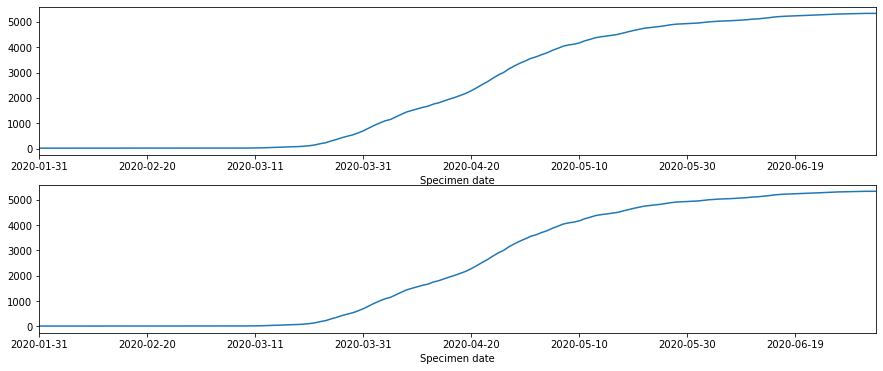

In [9]:
utla_of_interest = 'Essex'
key = 'Cumulative lab-confirmed cases'
# 1. computed UTLA values
series_utla = df_utla[df_utla['Area name'] == utla_of_interest].groupby('Specimen date').sum()[key]
# 2. summation of corresponding LTLA values
ltla_areas = df_ltla2utla[df_ltla2utla.UTLA19NM == utla_of_interest].LTLA19NM.values
print('UTLA: %s\nLTLA: %s' % (utla_of_interest, ' | '.join(ltla_areas)))
series_ltla_sum = df_ltla_clean[df_ltla_clean['Area name'].isin(ltla_areas)].groupby('Specimen date').sum()[key]
plt.figure(figsize=[15,6])
plt.subplot(2,1,1)
series_utla.plot()
plt.subplot(2,1,2)
series_ltla_sum.plot()
print('Difference = %d' % sum(series_utla - series_ltla_sum))

### Build lookup table: Local authority district > Region

In [10]:
l2r = {}
l2r_code = {}
for i in range(df_l2r.shape[0]):
    local = df_l2r.iloc[i].LAD19NM
    region = df_l2r.iloc[i].RGN19NM
    local_code = df_l2r.iloc[i].LAD19CD
    region_code = df_l2r.iloc[i].RGN19CD
    assert local not in l2r
    l2r[local] = region
    l2r_code[local_code] = region_code
# check integrity
assert len(set(l2r.values()) - set(df_uk[df_uk['Area type'] == 'Region']['Area name'])) == 0
assert len(set(df_ltla['Area name']) - set(l2r.keys())) == 0

### Merge counts at LTLA level into regional level

In [11]:
region_count = {}
for date in date_index:
    region_count[date] = {}
    df = df_ltla_clean[df_ltla_clean['Specimen date'] == date]
    for i in range(df.shape[0]):
        region = l2r[df.iloc[i]['Area name']]
        if region not in region_count[date]:
            region_code = l2r_code[df.iloc[i]['Area code']]
            region_count[date][region] = [region, region_code, 'Region', date, 0, 0]
            #print(region, last_date)
        region_count[date][region][4] += df.iloc[i]['Daily lab-confirmed cases']
        region_count[date][region][5] += df.iloc[i]['Cumulative lab-confirmed cases']
df_region = []
for date in region_count:
    for region in region_count[date]:
        df_region.append(region_count[date][region])
df_region = pd.DataFrame(df_region, columns=keys)
assert df_region.shape[0] == len(date_index) * df_region['Area name'].nunique()
df_region.tail()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Cumulative lab-confirmed cases
1399,East Midlands,E12000004,Region,2020-07-04,0.0,21076.0
1400,London,E12000007,Region,2020-07-04,0.0,33776.0
1401,West Midlands,E12000005,Region,2020-07-04,0.0,25323.0
1402,North West,E12000002,Region,2020-07-04,0.0,42604.0
1403,North East,E12000001,Region,2020-07-04,0.0,15071.0


### Integrity check

Region: London
LTLA: City of London | Barking and Dagenham | Barnet | Bexley | Brent | Bromley | Camden | Croydon | Ealing | Enfield | Greenwich | Hackney | Hammersmith and Fulham | Haringey | Harrow | Havering | Hillingdon | Hounslow | Islington | Kensington and Chelsea | Kingston upon Thames | Lambeth | Lewisham | Merton | Newham | Redbridge | Richmond upon Thames | Southwark | Sutton | Tower Hamlets | Waltham Forest | Wandsworth | Westminster
Difference = 0


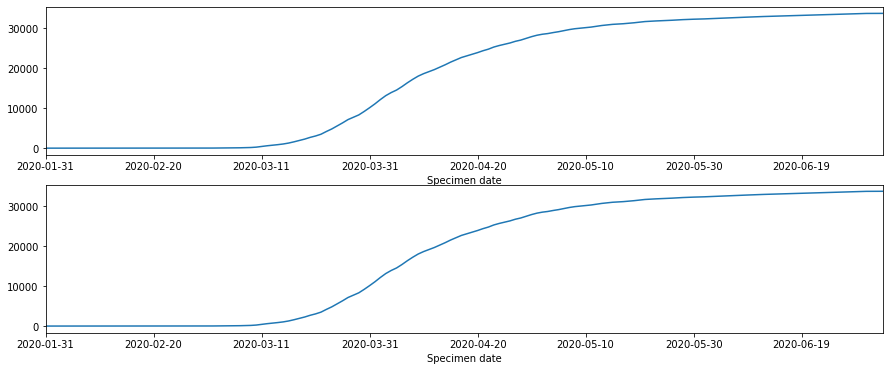

In [11]:
region_of_interest = 'London'
key = 'Cumulative lab-confirmed cases'
# 1. computed region values
series_region = df_region[df_region['Area name'] == region_of_interest].groupby('Specimen date').sum()[key]
# 2. summation of corresponding LTLA values
ltla_areas = df_l2r[df_l2r.RGN19NM == region_of_interest].LAD19NM.values
print('Region: %s\nLTLA: %s' % (region_of_interest, ' | '.join(ltla_areas)))
series_ltla_sum = df_ltla_clean[df_ltla_clean['Area name'].isin(ltla_areas)].groupby('Specimen date').sum()[key]
plt.figure(figsize=[15,6])
plt.subplot(2,1,1)
series_region.plot()
plt.subplot(2,1,2)
series_ltla_sum.plot()
print('Difference = %d' % sum(series_region - series_ltla_sum))

### Check naming consistency with neighbourhood data

In [12]:
df_area_uk = df_utla.sort_values('Specimen date').groupby(['Area name', 'Specimen date']).sum()
areas_uk = df_utla['Area name'].unique()
klaus_set = set(df_klaus.me_name)
our_set = set(areas_uk)
print('\nAreas defined in our data but not in Klaus data (Ours(%d) - Klaus(%d))' % (len(our_set), len(klaus_set)))
print(our_set - klaus_set)

keys = ['City of London', 'Somerset', 'Dorset', 'Suffolk',  'Wight', 'Cornwall', 'Bournemouth']
print('\nSearching for minimal keywords that exist in Klaus dataframe')
for key in keys:
    print(key)
    for area in klaus_set:
        if key in area:
            print('-> %s' % area)


Areas defined in our data but not in Klaus data (Ours(149) - Klaus(386))
{'Warwickshire', 'Devon', 'Somerset', 'Kent', 'Derbyshire', 'Northamptonshire', 'Norfolk', 'Isle of Wight', 'Worcestershire', 'Cumbria', 'Buckinghamshire', 'Essex', 'Hampshire', 'North Yorkshire', 'Cambridgeshire', 'Staffordshire', 'Gloucestershire', 'Surrey', 'Hertfordshire', 'Oxfordshire', 'Suffolk', 'Lincolnshire', 'Nottinghamshire', 'Bournemouth, Christchurch and Poole', 'East Sussex', 'Lancashire', 'West Sussex', 'Leicestershire'}

Searching for minimal keywords that exist in Klaus dataframe
City of London
-> City of London
Somerset
-> West Somerset
-> North Somerset
-> Bath and North East Somerset
-> South Somerset
Dorset
-> East Dorset
-> North Dorset
-> Dorset
-> West Dorset
Suffolk
-> Mid Suffolk
-> Suffolk Coastal
Wight
Cornwall
-> Cornwall
Bournemouth
-> Bournemouth


### Build neighbour list at UTLA level

In [12]:
utla_neighbours = {}
exceptions = set()
for i in range(df_klaus.shape[0]):
    if df_klaus.iloc[i]['me_name'] not in l2u:
        exceptions.add(df_klaus.iloc[i]['me_name'])
        continue
    if df_klaus.iloc[i]['neighbour_name'] not in l2u:
        exceptions.add(df_klaus.iloc[i]['neighbour_name'])
        continue
    utla_me = l2u[df_klaus.iloc[i]['me_name']]
    utla_nei = l2u[df_klaus.iloc[i]['neighbour_name']]
    if utla_me not in utla_neighbours:
        utla_neighbours[utla_me] = set()
    utla_neighbours[utla_me].add(utla_nei)
for e in exceptions:
    if e in df_utla['Area name'].unique():
        print('%s not found in lookup table' % e)

In [22]:
region_neighbours

{'North East': {'North East', 'North West', 'Yorkshire and The Humber'},
 'North West': {'East Midlands',
  'North East',
  'North West',
  'West Midlands',
  'Yorkshire and The Humber'},
 'Yorkshire and The Humber': {'East Midlands',
  'North East',
  'North West',
  'Yorkshire and The Humber'},
 'East Midlands': {'East Midlands',
  'East of England',
  'North West',
  'South East',
  'West Midlands',
  'Yorkshire and The Humber'},
 'West Midlands': {'East Midlands',
  'North West',
  'South East',
  'South West',
  'West Midlands'},
 'South West': {'South East', 'South West', 'West Midlands'},
 'East of England': {'East Midlands',
  'East of England',
  'London',
  'South East'},
 'South East': {'East Midlands',
  'East of England',
  'London',
  'South East',
  'South West',
  'West Midlands'},
 'London': {'East of England', 'London', 'South East'}}

In [29]:
# print('-- Undefined areas in neighbours dataframe --')
# for a in areas_uk:
#     if a not in utla_neighbours:
#         print(a)

### Build neighbourhood list at regional level

In [14]:
region_neighbours = {}
exceptions = set()
for i in range(df_klaus.shape[0]):
    if df_klaus.iloc[i]['me_name'] not in l2r:
        exceptions.add(df_klaus.iloc[i]['me_name'])
        continue
    if df_klaus.iloc[i]['neighbour_name'] not in l2r:
        exceptions.add(df_klaus.iloc[i]['neighbour_name'])
        continue
    region_me = l2r[df_klaus.iloc[i]['me_name']]
    region_nei = l2r[df_klaus.iloc[i]['neighbour_name']]
    if region_me not in region_neighbours:
        region_neighbours[region_me] = set()
    region_neighbours[region_me].add(region_nei)
for e in exceptions:
    if e in df_region['Area name'].unique():
        print('%s not found in lookup table' % e)

In [26]:
df_uk_clean.head()

,Area code,Area name,Area type,Cumulative lab-confirmed cases,Daily lab-confirmed cases,Specimen date
0,E06000014,York,Lower tier local authority,2.0,1.0,2020-01-31
1,E06000014,York,Lower tier local authority,2.0,1.0,2020-02-01
2,E06000014,York,Lower tier local authority,2.0,1.0,2020-02-02
3,E06000014,York,Lower tier local authority,2.0,1.0,2020-02-03
4,E06000014,York,Lower tier local authority,2.0,1.0,2020-02-04


In [20]:
%store region_neighbours

%store utla_neighbours


Stored 'region_neighbours' (dict)
Stored 'utla_neighbours' (dict)


In [25]:
df_uk_clean = df_ltla_clean.append(df_utla).append(df_region).reset_index(drop=True)
df_uk_clean.to_csv('/project_data/data_asset/coronavirus-cases_latest_clean.csv')


# from project_lib import Project

# project = Project.access()

# project.save_data(file_name = "coronavirus-cases_latest_clean.csv", data = risk_index_df_final.to_csv(index = False), overwrite = True)



/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


### Find the max risk index from neighbours

In [15]:
def find_neighbour_risk_index(area_hierarchy, area, risk_index):
    """
    area_hierarchy: 'region' or 'utla'
    area: e.g. 'North West'
    risk_index: {area:risk_index} which includes all areas
    """
    if area_hierarchy == 'region':
        neighbours = region_neighbours[area]
    elif area_hierarchy == 'utla':
        neighbours = utla_neighbours[area]
    else:
        raise ValueError('Unknown area hierarchy %s' % area_hierarachy)
#     max_risk = risk_index[area]  -- old code
    
    max_risk = 0.  ## new code

    for neighbour in neighbours:
        if risk_index[neighbour] > max_risk:
            max_risk = risk_index[neighbour]
    return max_risk

### Example use case

In [16]:
import random

risk_index = {}
for n in region_neighbours:
    risk_index[n] = random.random()
print('\n'.join(['%s: %.2f' % (area, risk_index[area]) for area in risk_index]))

North East: 0.19
North West: 0.81
Yorkshire and The Humber: 0.72
East Midlands: 0.36
West Midlands: 0.08
South West: 0.14
East of England: 0.94
South East: 0.32
London: 0.80


In [23]:
print('>> Risk index of London considering neighbours = %.2f' % find_neighbour_risk_index('region', 'London', risk_index))
print('>> Risk index of Yorkshire and The Humber considering neighbours = %.2f' % find_neighbour_risk_index('region', 'Yorkshire and The Humber', risk_index))

>> Risk index of London considering neighbours = 0.90
>> Risk index of Yorkshire and The Humber considering neighbours = 0.88
